# Bootstrapping Lab

In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection
import sklearn.linear_model

## 1. Constructing confidence intervals via bootstrapping

In [141]:
# From PTSD paper, there were 52 test cases, 42 of which were correct
n = 52
c = 42

# Create array of zeros, size n
rawdata = np.zeros(n)

# Set first c elements to 1
rawdata[range(c)] = 1

# Create pandas data frame
data = pd.DataFrame({"Match": rawdata})
data.head()

,Match
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


In [142]:
# Compute 10000 bootstrap datasets, compute means in each

def createBootstrapMeans(data, numboot=10000):
    n = len(data)
    boot_means = np.zeros(numboot)
    np.random.seed(0)
    for i in range(numboot):
        d = data.sample(n, replace=True)
        boot_means[i] = d.mean()
    return boot_means

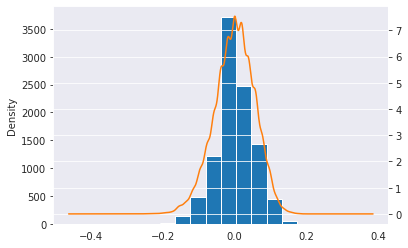

boot_quant: [-0.11538462  0.09615385]
Boot Confidence Interval: [0.712, 0.923]


In [143]:
# even though we are not using seaborn we can style the plots with it
sns.set_style("darkgrid") 

# Create a dataframe
bm = pd.DataFrame(data=createBootstrapMeans(data)-data.Match.mean(), columns=['samples'])

# Plot histogram and KDE
ax = bm.samples.plot(kind='hist')
bm.samples.plot(kind='kde', ax=ax, secondary_y=True)
plt.show()

# Bootstrap with CL of 95%
boot_CL = 95/100 
p_1 = (1-boot_CL)/2
p_2 = 1-p_1
boot_quant = np.quantile(bm, [p_1, p_2])
print('boot_quant:',boot_quant)

# Compute confidence interval
boot_ci = [(data.Match.mean() - boot_quant[1]).round(3), 
           (data.Match.mean() - boot_quant[0]).round(3)]
print("Boot Confidence Interval:",boot_ci)

# From the previous lab we know:
# Norm    CI: [0.7, 0.916]
# t-based CI: [0.697 0.918]

## 2. Bootstrap of a regression model

### 2.1. Making a model

In [144]:
# Data: 1000 births from North Carolina
# https://www.openintro.org/stat/data/?data=nc
# We are interested in the link between 
# Weeks: gestation time (length of the pregnancy in weeks) 
# Weight: Birth weight im pounds
D = pd.read_csv("nc.csv")
D.head()

,fage,mage,mature,weeks,premie,visits,marital,gained,weight,lowbirthweight,gender,habit,whitemom
0,NaN,13,younger mom,39.0,full term,10.0,married,38.0,7.63,not low,male,nonsmoker,not white
1,NaN,14,younger mom,42.0,full term,15.0,married,20.0,7.88,not low,male,nonsmoker,not white
2,19.0,15,younger mom,37.0,full term,11.0,married,38.0,6.63,not low,female,nonsmoker,white
3,21.0,15,younger mom,41.0,full term,6.0,married,34.0,8.00,not low,male,nonsmoker,white
4,NaN,15,younger mom,39.0,full term,9.0,married,27.0,6.38,not low,female,nonsmoker,not white


In [145]:
# Check for missing data and exclude observations
print("Number of NaN:",sum(np.isnan(D.weeks)))
D = D[~np.isnan(D.weeks)]

Number of NaN: 2


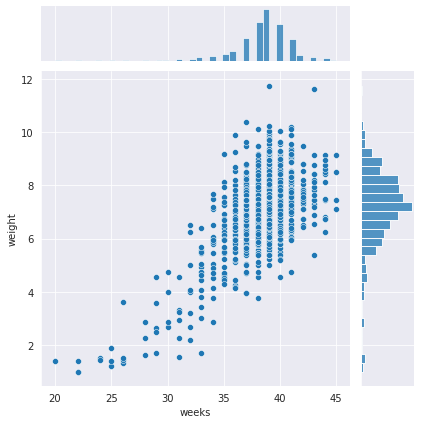

In [146]:
# Make a Joint plot between weeks and weight
sns.jointplot(data=D, x='weeks', y='weight')

# # You can also plot the joint probability distribution
# kdeplot = sns.jointplot(data=D, x='weeks', y='weight', kind='kde', fill=True, cbar=True)
# plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)
# # get the current positions of the joint ax and the ax for the marginal x
# pos_joint_ax = kdeplot.ax_joint.get_position()
# pos_marg_x_ax = kdeplot.ax_marg_x.get_position()
# # reposition the joint ax so it has the same width as the marginal x ax
# kdeplot.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, pos_marg_x_ax.width, pos_joint_ax.height])
# # reposition the colorbar using new x positions and y positions of the joint ax
# kdeplot.fig.axes[-1].set_position([.83, pos_joint_ax.y0, .07, pos_joint_ax.height])

plt.show()

In [147]:
# Train a model on the training set
regr = sklearn.linear_model.LinearRegression()
X_fit = np.c_[D.weeks, D.weeks**2, D.weeks**3]
regr.fit(X_fit, D.weight)
regr.coef_

array([-5.21866875e+00,  1.78832738e-01, -1.85596626e-03])

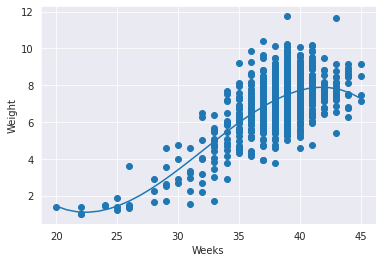

In [148]:
# Plot the Fit of model 
plt.scatter(D.weeks, D.weight)
p_weeks = np.linspace(D.weeks.min(), D.weeks.max(), 30)
X_pred = np.c_[p_weeks, p_weeks**2, p_weeks**3]
p_weight=regr.predict(X_pred)

plt.plot(p_weeks, p_weight)
plt.xlabel("Weeks")
plt.ylabel("Weight")
plt.show()

### 2.2. Bootstrap the model parameters

In [149]:
# Write a Bootstrap function that records the fitted models 
def BootstrapCoef(data, numboot=1000):
    n = len(data)
    theta = np.zeros((numboot,3))    
    for i in range(numboot):
        d = data.sample(n, replace=True)
        X_fit = np.c_[d.weeks,d.weeks**2,d.weeks**3]
        regr.fit(X_fit,d.weight)
        theta[i,:]=regr.coef_
    return theta

In [150]:
# Get 1000 Bootstrap fits
thetaBS = BootstrapCoef(D)
print(thetaBS.shape)
thetaBS

(1000, 3)


array([[-5.08561068e+00,  1.75309065e-01, -1.82490474e-03],
       [-6.49713727e+00,  2.17645206e-01, -2.24009841e-03],
       [-5.85704373e+00,  1.98209716e-01, -2.04922007e-03],
       ...,
       [-4.39197969e+00,  1.51518868e-01, -1.56551476e-03],
       [-4.84220682e+00,  1.68968512e-01, -1.77711026e-03],
       [-4.91776054e+00,  1.69693545e-01, -1.76569533e-03]])

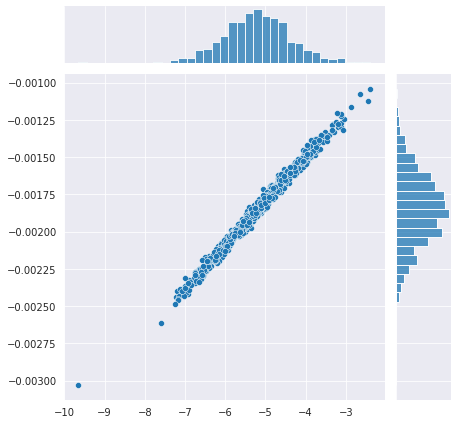

In [151]:
# Make a joint plot of two parameters 
sns.jointplot(x=thetaBS[:,0],y=thetaBS[:,2])
plt.xlabel(r"$\beta_{0}$")
plt.ylabel(r"$\beta_{2}$")
plt.show()

### 2.3. Bootstrap the model prediction

In [152]:
# Write a Bootstrap function that records the fitted models 
def BootstrapPred(data, xp, numboot=1000):
    n = len(data)
    X_pred = np.c_[xp,xp**2,xp**3]
    y_pred = np.zeros((numboot,X_pred.shape[0]))    
    for i in range(numboot):
        d = data.sample(n, replace=True)
        X_fit = np.c_[d.weeks,d.weeks**2,d.weeks**3]
        regr.fit(X_fit,d.weight)
        y_pred[i,:]=regr.predict(X_pred)
    return y_pred

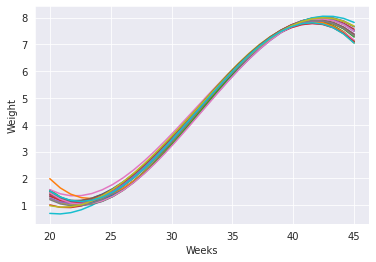

In [153]:
# Plot 20 of the bootstrapped predictions 
yhat_s    = p_weight
yhat_boot = BootstrapPred(D, p_weeks)

for i in range(20):
    plt.plot(p_weeks, yhat_boot[i,:])

plt.xlabel("Weeks")
plt.ylabel("Weight")
plt.show()

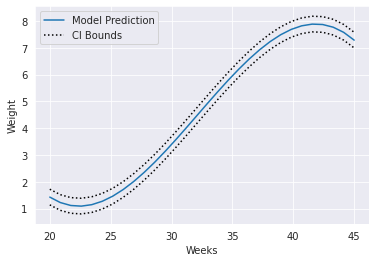

In [154]:
# Calculate upper and lower confidence bounds for prediction by bootstrapping

boot_CL = 95/100 
p_1 = (1-boot_CL)/2
p_2 = 1-p_1

boot_quant = np.quantile(yhat_boot-yhat_s, [p_1, p_2])

boot_ci = [yhat_s - boot_quant[0], 
           yhat_s - boot_quant[1]]

# Plot prediction
plt.plot(p_weeks, yhat_s, label="Model Prediction")

# plot CI
plt.plot(p_weeks, boot_ci[0],'k:', label="CI Bounds")
plt.plot(p_weeks, boot_ci[1],'k:')
plt.xlabel("Weeks")
plt.ylabel("Weight")
plt.legend()
plt.show()